In [ ]:
pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.0
    Uninstalling joblib-1.4.0:
      Successfully uninstalled joblib-1.4.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import random_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import StandardScaler
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
%matplotlib inline
plt.style.use('seaborn')

<ipython-input-2-8dd51c1ad2a5>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Conjunto de Datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filePath = '/content/drive/MyDrive'

In [ ]:
df_time_series_humedad = pd.read_csv(f'{filePath}/Finca_SanLuis_dataset_soil_2015_2024.csv')

In [ ]:
df_time_series_humedad

,Band name,Band value
0,20150331_0130_sm_rootzone,0.284
1,20150331_0430_sm_rootzone,0.284
2,20150331_0730_sm_rootzone,0.285
3,20150331_1030_sm_rootzone,0.285
4,20150331_1330_sm_rootzone,0.284
...,...,...
25650,20240109_1030_sm_rootzone,0.259
25651,20240109_1330_sm_rootzone,0.258
25652,20240109_1630_sm_rootzone,0.258
25653,20240109_1930_sm_rootzone,0.257


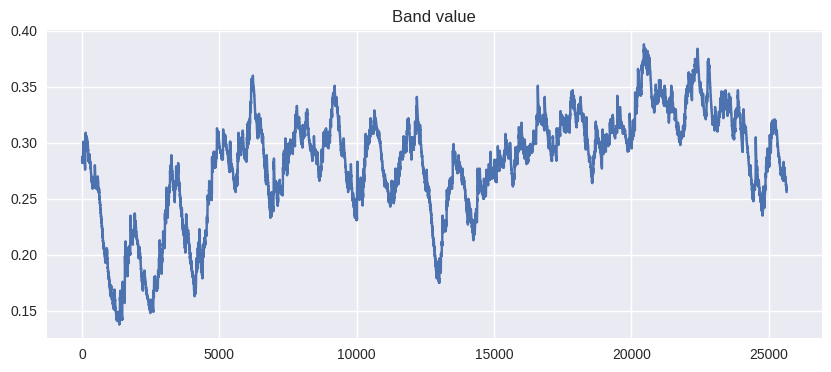

In [ ]:
df_time_series_humedad['Band value'].plot(kind='line', figsize=(10, 4), title='Band value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
df_time_series_humedad['Band name'] = pd.to_datetime(df_time_series_humedad['Band name'], format='%Y%m%d_%H%M_sm_rootzone')
df_time_series_humedad['date']=df_time_series_humedad['Band name'].dt.date
df_time_series_humedad_mean_day=df_time_series_humedad.groupby('date')['Band value'].mean().reset_index()
df_time_series_humedad_mean_day.rename(columns={'Band value': 'sm_rootzone'}, inplace=True)
df_time_series_humedad_mean_day

#df_time_series_humedad['Band name'] = pd.to_datetime(df_time_series_humedad['Band name'], format='%Y%m%d_%H%M_sm_rootzone')
#df_time_series_humedad.rename(columns={'Band value': 'sm_rootzone'}, inplace=True)
#df_time_series_humedad

,date,sm_rootzone
0,2015-03-31,0.283875
1,2015-04-01,0.286375
2,2015-04-02,0.286250
3,2015-04-03,0.284875
4,2015-04-04,0.284250
...,...,...
3202,2024-01-05,0.266250
3203,2024-01-06,0.264250
3204,2024-01-07,0.262125
3205,2024-01-08,0.260125


In [ ]:
df_time_series_humedad_mean_day = df_time_series_humedad_mean_day.set_index('date')
df_time_series_humedad_mean_day = df_time_series_humedad_mean_day.asfreq('d')
df_time_series_humedad_mean_day
#df_time_series_humedad = df_time_series_humedad.set_index('Band name')
#df_time_series_humedad = df_time_series_humedad.asfreq('3H')
#df_time_series_humedad

,sm_rootzone
date,
2015-03-31,0.283875
2015-04-01,0.286375
2015-04-02,0.286250
2015-04-03,0.284875
2015-04-04,0.284250
...,...
2024-01-05,0.266250
2024-01-06,0.264250
2024-01-07,0.262125


In [ ]:
df_time_series_humedad['hour']=df_time_series_humedad['Band name'].dt.time
df_time_series_humedad

,Band name,Band value,date,hour
0,2015-03-31 01:30:00,0.284,2015-03-31,01:30:00
1,2015-03-31 04:30:00,0.284,2015-03-31,04:30:00
2,2015-03-31 07:30:00,0.285,2015-03-31,07:30:00
3,2015-03-31 10:30:00,0.285,2015-03-31,10:30:00
4,2015-03-31 13:30:00,0.284,2015-03-31,13:30:00
...,...,...,...,...
25650,2024-01-09 10:30:00,0.259,2024-01-09,10:30:00
25651,2024-01-09 13:30:00,0.258,2024-01-09,13:30:00
25652,2024-01-09 16:30:00,0.258,2024-01-09,16:30:00
25653,2024-01-09 19:30:00,0.257,2024-01-09,19:30:00


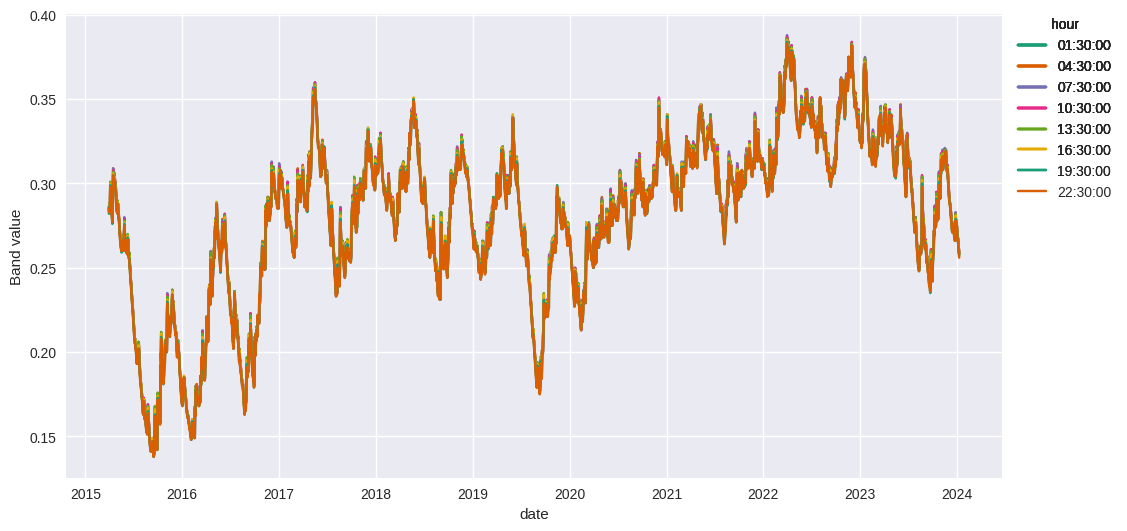

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['Band value']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_time_series_humedad.sort_values('date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('hour')):
  _plot_series(series, series_name, i)
  fig.legend(title='hour', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('Band value')

# Exploración del Conjunto de Datos

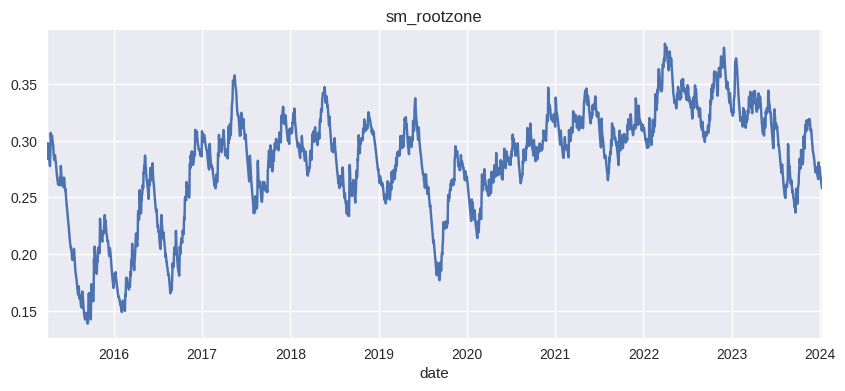

In [ ]:
df_time_series_humedad_mean_day['sm_rootzone'].plot(kind='line', figsize=(10, 4), title='sm_rootzone')
#df_time_series_humedad['sm_rootzone'].plot(kind='line', figsize=(10, 4), title='sm_rootzone')
plt.gca().spines[['top', 'right']].set_visible(False)

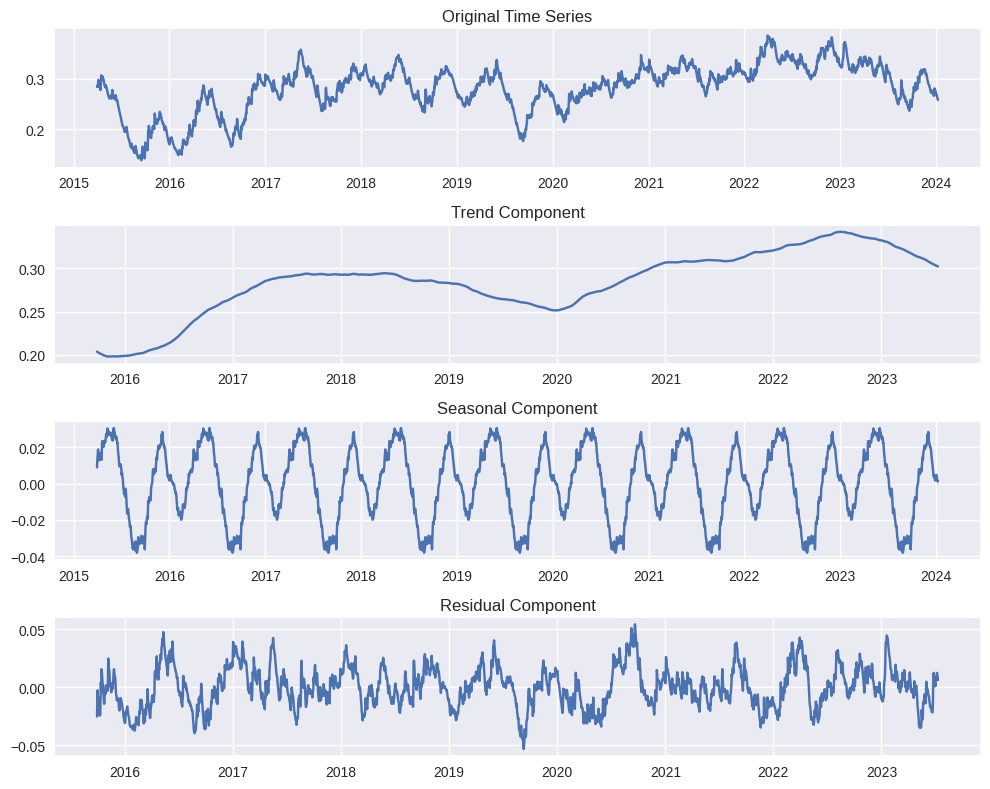

In [ ]:
df_time_series_humedad_mean_day.index = pd.to_datetime(df_time_series_humedad_mean_day.index)

# Perform seasonal decomposition
result = seasonal_decompose(df_time_series_humedad_mean_day['sm_rootzone'], model='additive', period=365)

# Plot the components
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# Original time series
axes[0].plot(df_time_series_humedad_mean_day.index, df_time_series_humedad_mean_day['sm_rootzone'], label='Original')
axes[0].set_title('Original Time Series')

# Trend component
axes[1].plot(result.trend, label='Trend')
axes[1].set_title('Trend Component')

# Seasonal component
axes[2].plot(result.seasonal, label='Seasonal')
axes[2].set_title('Seasonal Component')

# Residual component
axes[3].plot(result.resid, label='Residual')
axes[3].set_title('Residual Component')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

<ipython-input-72-a6c19e777c66>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_time_series_humedad_mean_day['sm_rootzone'])


<Axes: xlabel='sm_rootzone', ylabel='Density'>

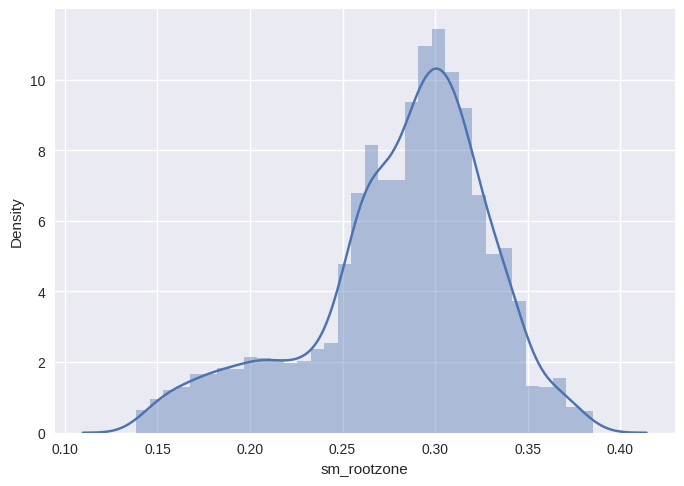

In [ ]:
sns.distplot(df_time_series_humedad_mean_day['sm_rootzone'])

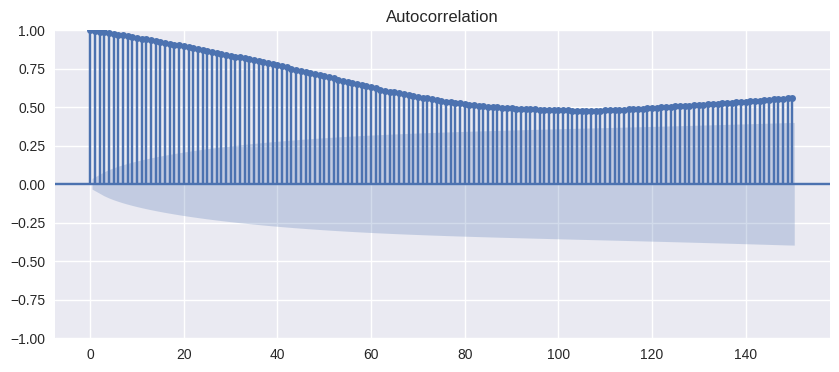

In [ ]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df_time_series_humedad_mean_day['sm_rootzone'], ax=ax, lags=150)
#plot_acf(df_time_series_humedad['sm_rootzone'], ax=ax, lags=150)
plt.show()

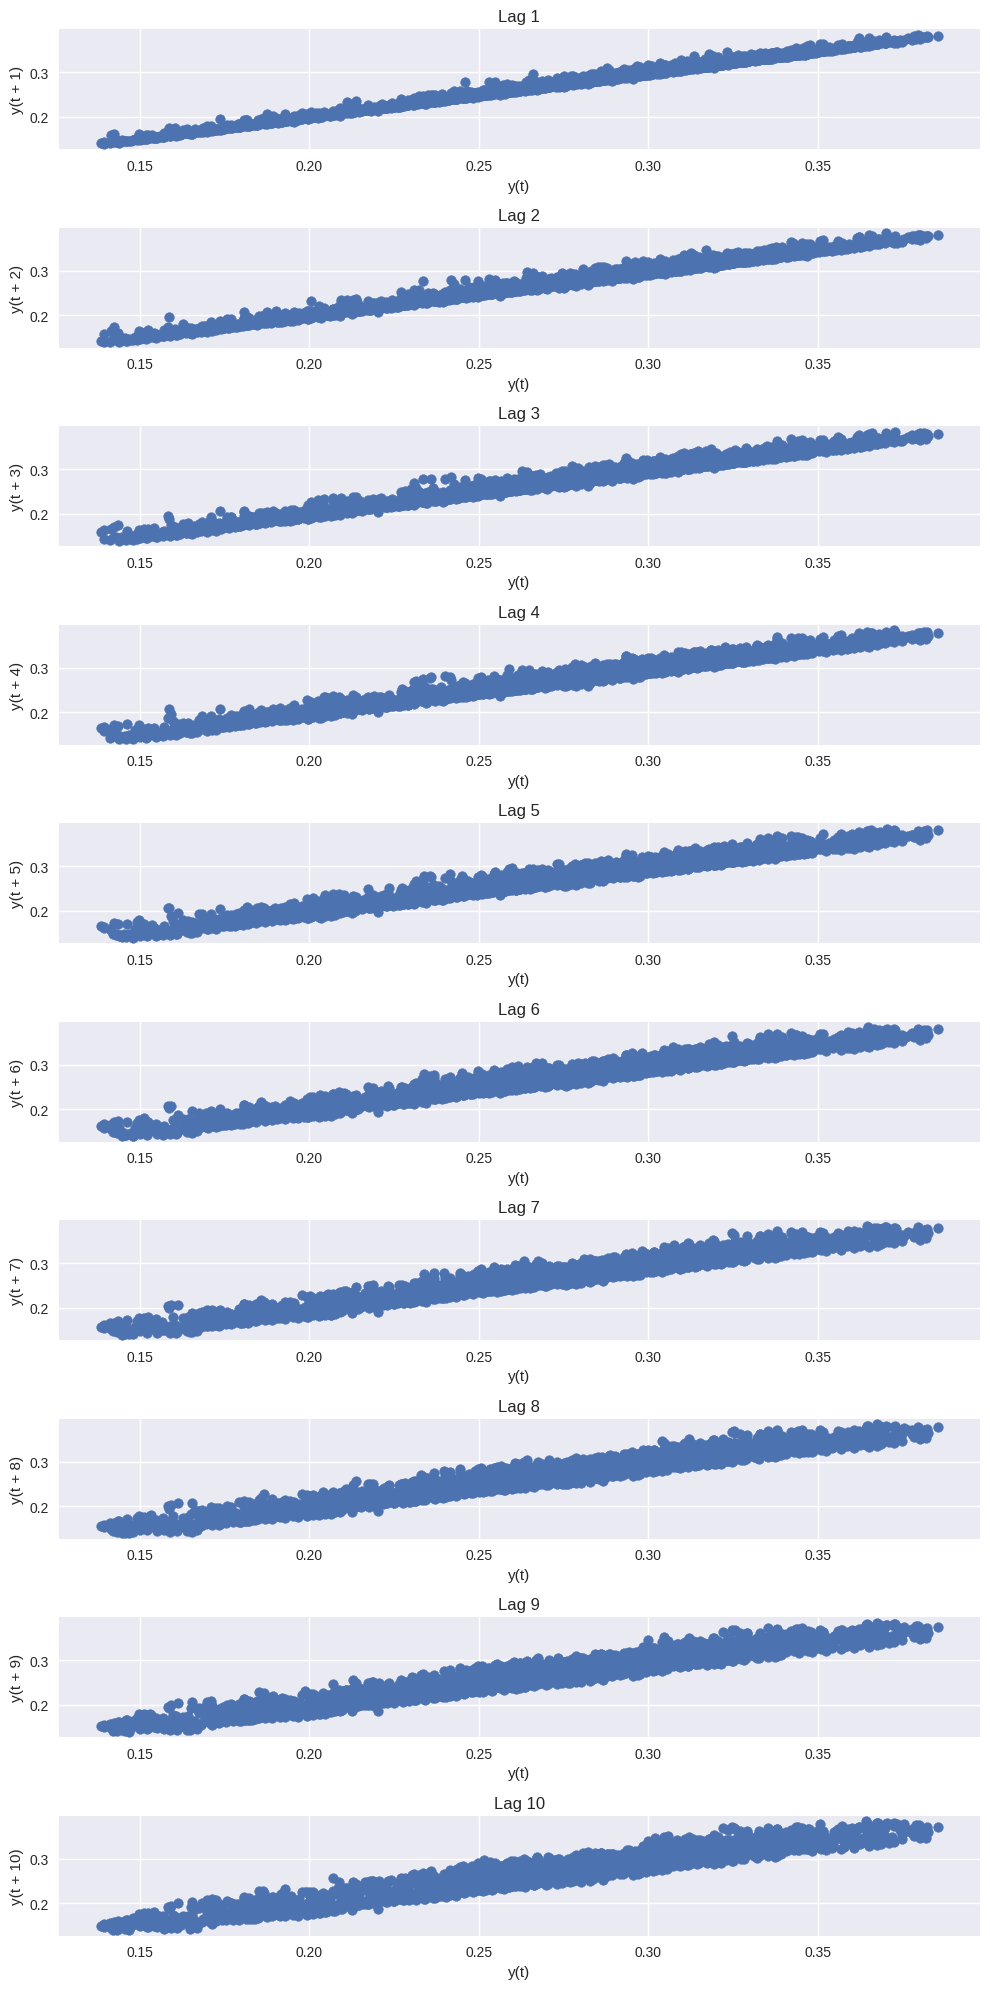

In [ ]:
# Generate lag plots for the first 10 lags
lags = 10

# Create subplots
fig, axes = plt.subplots(nrows=lags, ncols=1, figsize=(10, 2 * lags))

# Loop through the lags and plot each on a separate subplot
for lag in range(1, lags + 1):
    lag_plot(df_time_series_humedad_mean_day['sm_rootzone'], lag=lag, ax=axes[lag - 1])
    axes[lag - 1].set_title(f'Lag {lag}')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

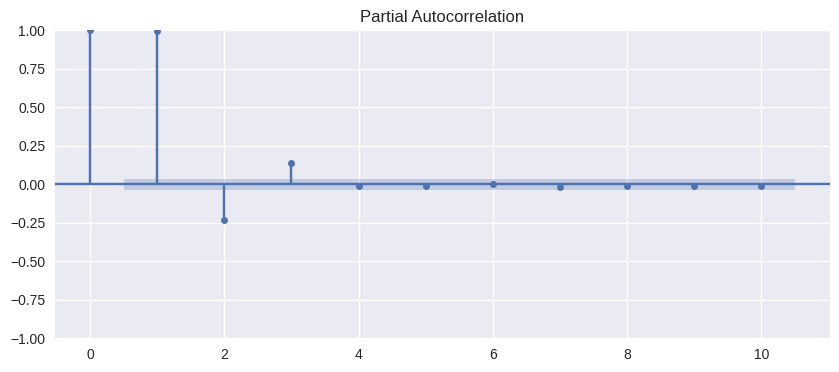

In [ ]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 4))
plot_pacf(df_time_series_humedad_mean_day['sm_rootzone'], ax=ax, lags=10, method='ywm')
plt.show()

In [ ]:
print("Number of missing values: ", df_time_series_humedad_mean_day.isnull().sum().sum())
print("Número de valores na: "),df_time_series_humedad_mean_day.isna().sum()

Number of missing values:  0
Número de valores na: 


(None,
 sm_rootzone    0
 dtype: int64)

In [ ]:
def adf_test(x):
    result = adfuller(x)
    pvalue= result[1]
    print(pvalue)
    if pvalue < 0.05:
        print("Estacionaria")
    else:
        print("NO estacionaria")

In [ ]:
adf_test(df_time_series_humedad_mean_day['sm_rootzone'])

0.07631014735737397
NO estacionaria


In [ ]:
# Differentiate the 'sm_rootzone' column
df_time_series_humedad_mean_day['sm_rootzone_diff'] = df_time_series_humedad_mean_day['sm_rootzone'].diff()

<Axes: xlabel='date'>

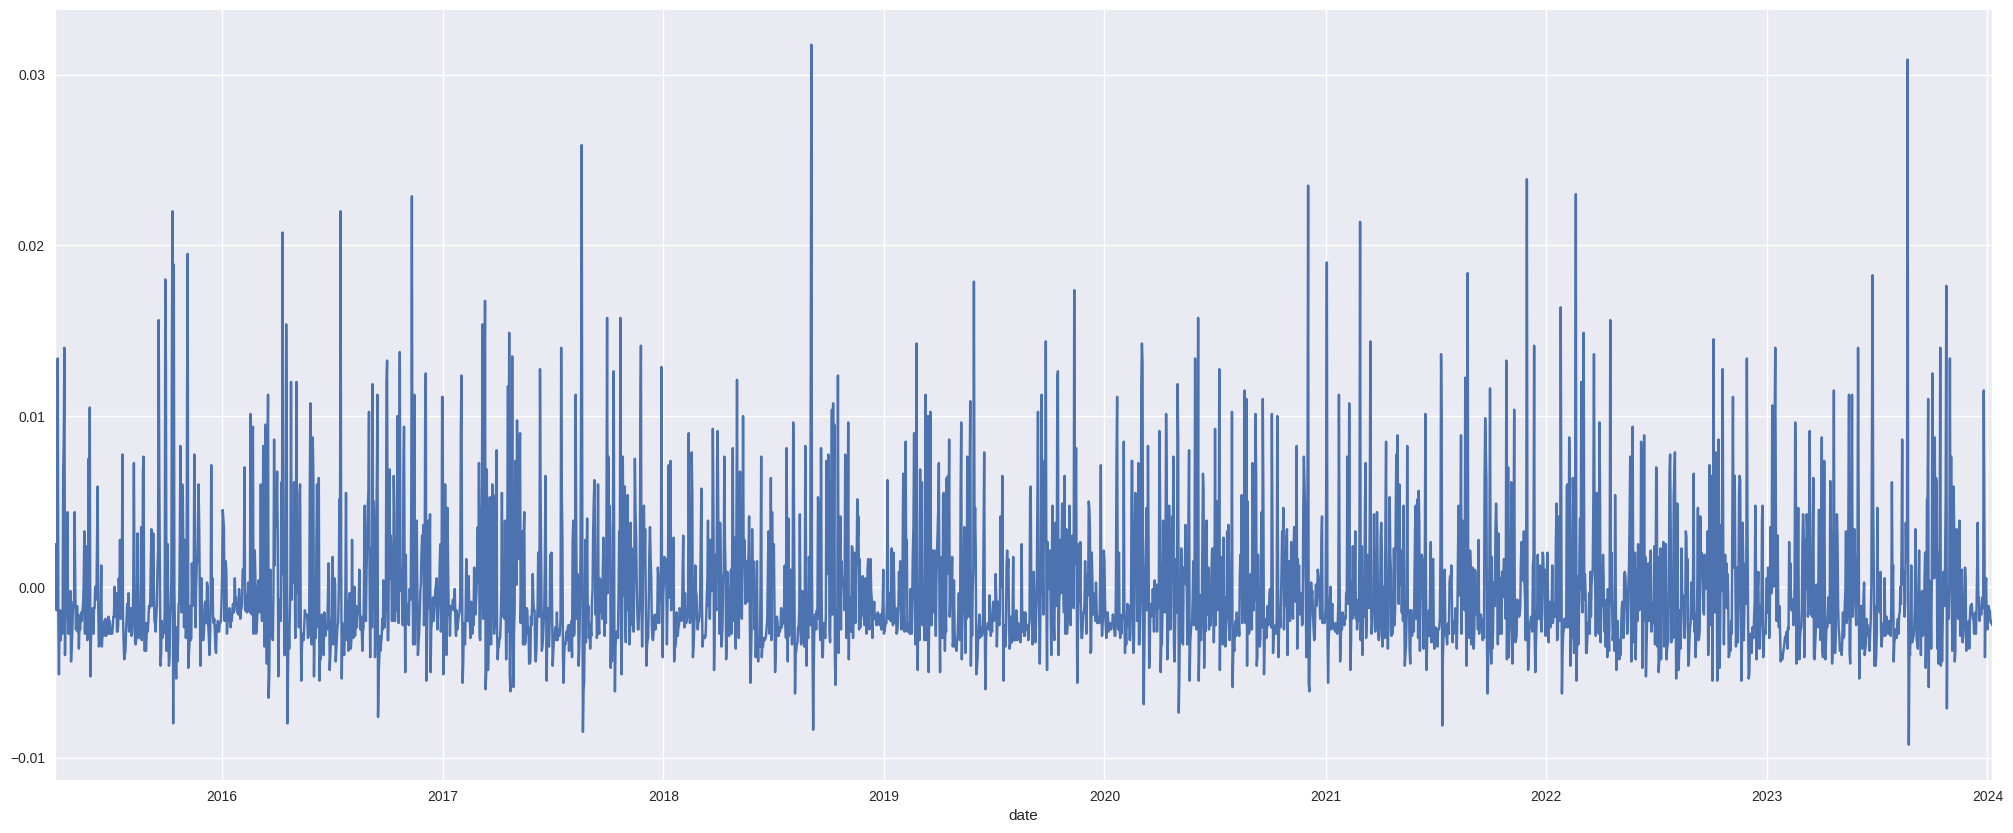

In [ ]:
df_time_series_humedad_mean_day['sm_rootzone_diff'].plot(figsize =(25, 10))

In [ ]:
print("Number of missing values: ", df_time_series_humedad_mean_day.isnull().sum().sum())
print("Número de valores na: "),df_time_series_humedad_mean_day.isna().sum()

Number of missing values:  1
Número de valores na: 


(None,
 sm_rootzone         0
 sm_rootzone_diff    1
 dtype: int64)

In [ ]:
df_time_series_humedad_mean_day[df_time_series_humedad_mean_day.isnull().any(1)]

TypeError: NDFrame._add_numeric_operations.<locals>.any() takes 1 positional argument but 2 were given

In [ ]:
df_time_series_humedad_mean_day.iloc[1:, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone_diff')]

date
2015-04-01    0.002500
2015-04-02   -0.000125
2015-04-03   -0.001375
2015-04-04   -0.000625
2015-04-05    0.013375
                ...   
2024-01-05   -0.001375
2024-01-06   -0.002000
2024-01-07   -0.002125
2024-01-08   -0.002000
2024-01-09   -0.002250
Freq: D, Name: sm_rootzone_diff, Length: 3206, dtype: float64

In [ ]:
adf_test(df_time_series_humedad_mean_day.iloc[1:, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone_diff')])

0.0
Estacionaria


# Machine Learning

primero 70 training y 15 validacion y 15 test
segundo ejecutar el naive forecasting como modelo base
tercero back testing con el naive forecasting y la metrica rmse
probar algoritmo LightGBM , random forest, ltsm y phonet
probar lo mismo pero diferenciado la serie
horizonte maximo 7 dias, probar 3 dias y dias

Conjuntos de entrenamiento, validación y prueba.

Dates train      : 2015-03-31 00:00:00 --- 2021-05-21 00:00:00  (n=2244)
Dates valid : 2021-05-22 00:00:00 --- 2022-09-14 00:00:00  (n=481)
Dates test       : 2022-09-15 00:00:00 --- 2024-01-09 00:00:00  (n=482)


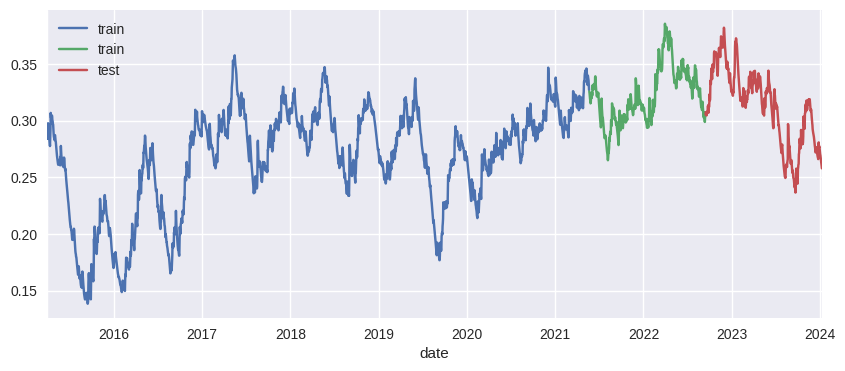

In [ ]:
samples_training = int(len(df_time_series_humedad_mean_day) * 0.7)
samples_validation = int(len(df_time_series_humedad_mean_day) * 0.15)
data_train = df_time_series_humedad_mean_day.iloc[:samples_training]
data_valid = df_time_series_humedad_mean_day.iloc[samples_training:samples_training + samples_validation]
data_test = df_time_series_humedad_mean_day.iloc[samples_training + samples_validation:]
print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates valid : {data_valid.index.min()} --- {data_valid.index.max()}  (n={len(data_valid)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")
fig, ax = plt.subplots(figsize=(10, 4))
data_train['sm_rootzone'].plot(ax=ax, label='train')
data_valid['sm_rootzone'].plot(ax=ax, label='train')
data_test['sm_rootzone'].plot(ax=ax, label='test')
ax.legend();

##Modelo Base (Baseline)

In [ ]:
# Random walk simulation
# ==============================================================================
df_rw = df_time_series_humedad_mean_day[['sm_rootzone']].copy()
df_rw['pred_rootzone'] = df_rw['sm_rootzone'].shift(1)

# Test error
# ==============================================================================
end_train='2023-04-09'
y_true = df_rw.loc[end_train:, 'sm_rootzone']
y_pred = df_rw.loc[end_train:, 'pred_rootzone']
metric = mean_absolute_error(y_true, y_pred)

print(f'Test error: {metric}')
display(df_rw.loc[end_train:,].tail(4))

Test error: 0.002971014492753621


,sm_rootzone,pred_rootzone
date,,
2024-01-06,0.264250,0.266250
2024-01-07,0.262125,0.264250
2024-01-08,0.260125,0.262125
2024-01-09,0.257875,0.260125


In [ ]:
print('MSE:',mean_squared_error(y_true,y_pred))
print('RMSE:',mean_squared_error(y_true,y_pred,squared=False))
print('MAPE:',mean_absolute_percentage_error(y_true,y_pred))
print('MAE:', mean_absolute_error(y_true,y_pred))

MSE: 1.902360387089616e-05
RMSE: 0.004361605652841182
MAPE: 0.0101390316343705
MAE: 0.002971014492753621


## LGBMRegressor

Escenario 1

In [ ]:

# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = LGBMRegressor(random_state=15926, verbose=-1),
                 lags      = 3,
                 differentiation = 1,
                 transformer_y = StandardScaler()
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone')])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=15926, verbose=-1) 
Lags: [1 2 3] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 4 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-03-31 00:00:00'), Timestamp('2022-09-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2024-04-20 01:26:41 
Last fit date: 2

In [ ]:
predictions_LGMB= forecaster.predict(steps=len(data_test['sm_rootzone']))

In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions_LGMB))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions_LGMB,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions_LGMB))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions_LGMB))

MSE: 0.005825487851053137
RMSE: 0.0763248835639671
MAPE: 0.21195780209865422
MAE: 0.06100857033692811


In [ ]:
print(df_time_series_humedad_mean_day.index)

DatetimeIndex(['2015-03-31', '2015-04-01', '2015-04-02', '2015-04-03',
               '2015-04-04', '2015-04-05', '2015-04-06', '2015-04-07',
               '2015-04-08', '2015-04-09',
               ...
               '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07',
               '2024-01-08', '2024-01-09'],
              dtype='datetime64[ns]', name='date', length=3207, freq='D')


In [ ]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 161
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-17 00:00:00  (n=3)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-18 00:00:00 -- 2022-09-20 00:00:00  (n=3)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-21 00:00:00 -- 2022-09-23 00:00:00  (n=3)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-24 00:00:00 -- 2022-09-26 00:00:00  (n=

  0%|          | 0/161 [00:00<?, ?it/s]

,pred
2022-09-15,0.301109
2022-09-16,0.300815
2022-09-17,0.301488
2022-09-18,0.309346
2022-09-19,0.308699


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 4.2979381765477e-05
RMSE: 0.0065558662101569
MAPE: 0.01542457181365259
MAE: 0.004784674381450687


Text(0.5, 1.0, 'Comparison of data_test and predictions')

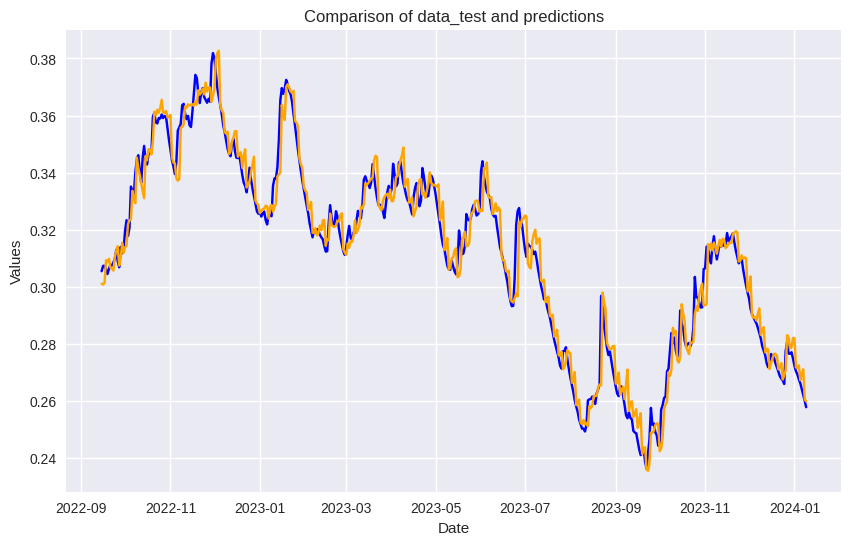

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting data_test
plt.plot(data_test.index, data_test['sm_rootzone'], label='data_test', color='blue')

# Plotting predictions
plt.plot(predictions.index, predictions['pred'], label='predictions', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of data_test and predictions')

Escenario 2, Hiperparametros usando conjunto de validación.

In [ ]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40]

# Regressor hyperparameters

param_distributions = {
    'max_depth': np.arange(start=-1, stop=10, step=1, dtype=int),
    'learning_rate'    : [0.001, 0.01, 0.1, 0.5],
    'n_estimators'     : [50,100,200, 500, 1000],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone')], # Test data not used
                                   steps                = 8,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_humedad_mean_day.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 90.


lags grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4] 
  Parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.01}
  Backtesting metric: 7.195394052751731e-05



In [ ]:
results_search.head(10)

,lags,params,mean_squared_error,n_estimators,max_depth,learning_rate
54,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.000038,1000.0,3.0,0.01
44,"[1, 2, 3, 4, 5]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.000038,1000.0,3.0,0.01
39,"[1, 2, 3, 4]","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000038,50.0,6.0,0.01
49,"[1, 2, 3, 4, 5]","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000039,50.0,6.0,0.01
59,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000039,50.0,6.0,0.01
29,"[1, 2, 3]","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000039,50.0,6.0,0.01
19,"[1, 2]","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000039,50.0,6.0,0.01
34,"[1, 2, 3, 4]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.000039,1000.0,3.0,0.01
69,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'n_estimators': 50, 'max_depth': 6, 'learning...",0.000039,50.0,6.0,0.01
24,"[1, 2, 3]","{'n_estimators': 1000, 'max_depth': 3, 'learni...",0.000039,1000.0,3.0,0.01


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(learning_rate=0.01, max_depth=3, n_estimators=1000,
              random_state=15926, verbose=-1) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 11 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-03-31 00:00:00'), Timestamp('2022-09-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_fr

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 8,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 61
    Number of steps per fold: 8
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-22 00:00:00  (n=8)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-23 00:00:00 -- 2022-09-30 00:00:00  (n=8)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-10-01 00:00:00 -- 2022-10-08 00:00:00  (n=8)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-10-09 00:00:00 -- 2022-10-16 00:00:00  (n=8

  0%|          | 0/61 [00:00<?, ?it/s]

,pred
2022-09-15,0.304349
2022-09-16,0.304718
2022-09-17,0.305934
2022-09-18,0.305928
2022-09-19,0.306482


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 0.00010846003062033415
RMSE: 0.010414414559654044
MAPE: 0.025285706469893716
MAE: 0.007796653860421572


Text(0.5, 1.0, 'Comparison of data_test and predictions')

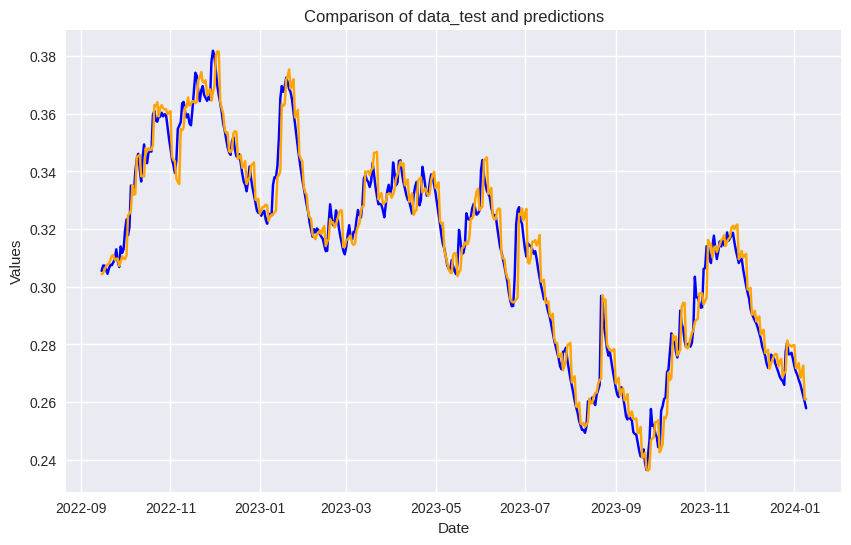

In [ ]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plotting data_test
plt.plot(data_test.index, data_test['sm_rootzone'], label='data_test', color='blue')

# Plotting predictions
plt.plot(predictions.index, predictions['pred'], label='predictions', color='orange')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Comparison of data_test and predictions')

Escenario 3, el backtesting usando refit con intermitencia de

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 161
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-17 00:00:00  (n=3)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-18 00:00:00 -- 2022-09-20 00:00:00  (n=3)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-21 00:00:00 -- 2022-09-23 00:00:00  (n=3)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-24 00:00:00 -- 2022-09-26 00:00:00  (n=

  0%|          | 0/161 [00:00<?, ?it/s]

,pred
2022-09-15,0.304349
2022-09-16,0.304718
2022-09-17,0.305934
2022-09-18,0.307128
2022-09-19,0.307756


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 4.3149092003448727e-05
RMSE: 0.0065687968459565505
MAPE: 0.015403074770524496
MAE: 0.00479313971873116


Guardar modelo

In [ ]:
import pickle

In [ ]:
filename = 'modelo_humedad_suelo.pkl'
pickle.dump(forecaster, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open(f'{filePath}/modelo_humedad_suelo.pkl', 'rb'))

In [ ]:
last_window = df_time_series_humedad_mean_day['sm_rootzone'].tail(11)

In [ ]:
input_data = (3)
prediction = loaded_model.predict(input_data,last_window=last_window)
print(prediction)

2024-01-10    0.256719
2024-01-11    0.256695
2024-01-12    0.258120
Freq: D, Name: pred, dtype: float64


## Random Forest

Escenario 1

In [ ]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 3,
                 differentiation = 1,
                 transformer_y = StandardScaler()
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone')])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 4 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-03-31 00:00:00'), Timestamp('2022-09-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-06 04:33:13 
Last fit date: 2024-02-06 04:33:14 
Skforecast version: 0.11.0 
Python version

In [ ]:
predictions_RF= forecaster.predict(steps=len(data_test['sm_rootzone']))
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions_RF))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions_RF,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions_RF))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions_RF))

MSE: 0.08458674471988639
RMSE: 0.2908380042564699
MAPE: 0.835365049689093
MAE: 0.24291971954653188


In [ ]:
# Backtest model on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 161
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-17 00:00:00  (n=3)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-18 00:00:00 -- 2022-09-20 00:00:00  (n=3)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-21 00:00:00 -- 2022-09-23 00:00:00  (n=3)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-24 00:00:00 -- 2022-09-26 00:00:00  (n=

  0%|          | 0/161 [00:00<?, ?it/s]

,pred
2022-09-15,0.303217
2022-09-16,0.304904
2022-09-17,0.305837
2022-09-18,0.311185
2022-09-19,0.312084


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 4.4188832600836316e-05
RMSE: 0.006647468134623612
MAPE: 0.015640200711949763
MAE: 0.004814146607412295


Escenario 2

In [ ]:
# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [1,2,3,4,5,10,20,30,40]

# Regressor hyperparameters

param_distributions = {
    'n_estimators': np.arange(start=10, stop=150, step=1, dtype=int),
    'max_depth': [None, 3,5,10,20,30],
    'max_features': [1,3,5,7,9],
}


results_search = random_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation, df_time_series_humedad_mean_day.columns.get_loc('sm_rootzone')], # Test data not used
                                   steps                = 3,
                                   lags_grid            = lags_grid,
                                   param_distributions  = param_distributions,
                                   n_iter               = 10,
                                   metric               = 'mean_squared_error',
                                   refit                = False,
                                   initial_train_size   = len(df_time_series_humedad_mean_day.iloc[:samples_training]),
                                   fixed_train_size     = False,
                                   return_best          = True,
                                   random_state         = 123,
                                   n_jobs               = 'auto',
                                   verbose              = False,
                                   show_progress        = True
                               )

Number of models compared: 90.


lags grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_estimators': 63, 'max_features': 3, 'max_depth': 5}
  Backtesting metric: 3.8615619431842315e-05



In [ ]:
results_search.head(10)

,lags,params,mean_squared_error,n_estimators,max_features,max_depth
24,"[1, 2, 3]","{'n_estimators': 63, 'max_features': 3, 'max_d...",0.000039,63.0,3.0,5.0
14,"[1, 2]","{'n_estimators': 63, 'max_features': 3, 'max_d...",0.000039,63.0,3.0,5.0
28,"[1, 2, 3]","{'n_estimators': 112, 'max_features': 3, 'max_...",0.000039,112.0,3.0,3.0
22,"[1, 2, 3]","{'n_estimators': 96, 'max_features': 9, 'max_d...",0.000039,96.0,9.0,3.0
12,"[1, 2]","{'n_estimators': 96, 'max_features': 9, 'max_d...",0.000039,96.0,9.0,3.0
55,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 106, 'max_features': 1, 'max_...",0.000039,106.0,1.0,NaN
18,"[1, 2]","{'n_estimators': 112, 'max_features': 3, 'max_...",0.000039,112.0,3.0,3.0
34,"[1, 2, 3, 4]","{'n_estimators': 63, 'max_features': 3, 'max_d...",0.000039,63.0,3.0,5.0
59,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'n_estimators': 121, 'max_features': 1, 'max_...",0.000039,121.0,1.0,NaN
42,"[1, 2, 3, 4, 5]","{'n_estimators': 96, 'max_features': 9, 'max_d...",0.000039,96.0,9.0,3.0


In [ ]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, max_features=3, n_estimators=63,
                      random_state=123) 
Lags: [1 2 3] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 4 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2015-03-31 00:00:00'), Timestamp('2022-09-14 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 3, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 63, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-02-06 04:33:13 
Last fit date: 2

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          refit              = False,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 161
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-17 00:00:00  (n=3)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-18 00:00:00 -- 2022-09-20 00:00:00  (n=3)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-21 00:00:00 -- 2022-09-23 00:00:00  (n=3)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-24 00:00:00 -- 2022-09-26 00:00:00  (n=

  0%|          | 0/161 [00:00<?, ?it/s]

,pred
2022-09-15,0.303516
2022-09-16,0.304049
2022-09-17,0.304872
2022-09-18,0.307904
2022-09-19,0.308747


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 4.1978720037080195e-05
RMSE: 0.0064790987056133195
MAPE: 0.01537935706122242
MAE: 0.004774260752362234


Escenario 3

In [ ]:
metric, predictions = backtesting_forecaster(
                          forecaster         = forecaster,
                          y                  = df_time_series_humedad_mean_day['sm_rootzone'],
                          steps              = 3,
                          metric             = 'mean_absolute_error',
                          initial_train_size = len(df_time_series_humedad_mean_day.iloc[:samples_training + samples_validation]),
                          allow_incomplete_fold = True,
                          refit              = 15,
                          fixed_train_size   = False,
                          n_jobs             = 'auto',
                          verbose            = True, # Change to False to see less information
                          show_progress      = True
                      )

predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 2724
    First 1 observation/s in training sets are used for differentiation
Number of observations used for backtesting: 482
    Number of folds: 161
    Number of steps per fold: 3
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-15 00:00:00 -- 2022-09-17 00:00:00  (n=3)
Fold: 1
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-18 00:00:00 -- 2022-09-20 00:00:00  (n=3)
Fold: 2
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-21 00:00:00 -- 2022-09-23 00:00:00  (n=3)
Fold: 3
    Training:   2015-04-01 00:00:00 -- 2022-09-14 00:00:00  (n=2724)
    Validation: 2022-09-24 00:00:00 -- 2022-09-26 00:00:00  (n=

  0%|          | 0/161 [00:00<?, ?it/s]

,pred
2022-09-15,0.303516
2022-09-16,0.304049
2022-09-17,0.304872
2022-09-18,0.307904
2022-09-19,0.308747


In [ ]:
print('MSE:',mean_squared_error(data_test['sm_rootzone'],predictions))
print('RMSE:',mean_squared_error(data_test['sm_rootzone'],predictions,squared=False))
print('MAPE:',mean_absolute_percentage_error(data_test['sm_rootzone'],predictions))
print('MAE:', mean_absolute_error(data_test['sm_rootzone'],predictions))

MSE: 4.2163557969876075e-05
RMSE: 0.006493347208480082
MAPE: 0.015432991226065524
MAE: 0.004786494610491914


## LSTM

1) probar el ltsm.
2) probar data set mas amplio.
3) probar datos de finca de andres.
4) probar ET
5)